# Main Aggregation Script - calls lab.py and crystals.py

In [1]:
#Reloads the lab.py and crystals.py modules to update any changes (after saving)
#If a new method or object is created, autoreload doesn't work and the 
#kernel needs to be closed and halted after saving and making a 'checkpoint'
#in this notebook

%load_ext autoreload
%autoreload 2

In [2]:
import ipas 
import numpy as np
import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
from dask import delayed
from dask import dataframe as dd
import functools
import sys
import ast
from struct import *
import pickle
import glob
import random
import pandas as pd
import time
from dask.distributed import as_completed
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt

In [3]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='20000MiB', #1 GiB = 1,024 MiB
    processes=1)

#cluster.adapt(minimum=3, maximum=20)
cluster.scale(8)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [4]:
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://169.226.65.44:36827 Dashboard: http://169.226.65.44:41405/status,Cluster Workers: 8 Cores: 8 Memory: 167.76 GB


# Initialize databases for queries

In [7]:
files = ['sqlite:///'+f for f in glob.glob("db_files/IPAS_*_lastmono.sqlite")]
tables = ['aggregates', 'crystals']

In [8]:
%%time

df=[]
for table in tables:
    
    #read tables in parallel on client 
    read_files = [dask.delayed(dd.read_sql_table)(table=table, uri=file, index_col='id') for file in files]
    
    compute_read = client.compute(read_files)
    print('done with compute')
    ddfs = client.gather(compute_read)
    print('done with gather')
    #concatenate all sqlite files vertically (axis=0 default) (same columns)
    gathered_reads = client.scatter(ddfs)
    ddf = client.submit(dd.concat, gathered_reads).result()
    print('done with submit')
    #append combined dask df for each table
    df.append(ddf)


done with compute
done with gather
done with submit
done with compute
done with gather
done with submit
CPU times: user 3.83 s, sys: 245 ms, total: 4.08 s
Wall time: 32.4 s


In [9]:
%time df_concat = dd.concat([df[0], df[1]], axis=1)

CPU times: user 4.87 ms, sys: 0 ns, total: 4.87 ms
Wall time: 5.32 ms


/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask/dataframe/multi.py:1055: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  "Concatenating dataframes with unknown divisions.\n"


In [10]:
df_concat.agg_r = np.power((np.power(df_concat.a, 2) * df_concat.c), (1./3.))

In [11]:
def query_r_5000(df):
    return df[df.agg_r < 5000]

df_concat = df_concat.map_partitions(query_r_5000)
#len(df_concat) #86% of dataset

In [12]:
df_repart = df_concat.repartition(partition_size="100MB").persist()
df_repart.npartitions

50

# MAIN

In [13]:
ch_dist='gamma'         #anything other than gamma uses the characteristic from the best distribution pdf (lowest SSE)
rand_orient = True  #randomly orient the seed crystal and new crystal: uses first random orientation

In [14]:
def query_ncrystals(df_phi, r_bins):
    avg_ncrystals = []
    for r in range(len(r_bins)-1):
        df = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1])]
        avg_ncrystals.append(df.ncrystals.mean().compute())
    return avg_ncrystals

def concatenate_points(agg):
    points = []
    ncrystals = agg.ncrystals.values[0]
    agg_id = agg.agg_id.values[0]
    #print('ncrystals, phi, r, agg_id')

    while ncrystals >= 2:
        query = df_repart[(df_repart.r == agg.r.values[0]) & (df_repart.phi == agg.phi.values[0]) & \
                     (df_repart.ncrystals == ncrystals) & (df_repart.agg_id == agg_id)].compute()

        #print(query.ncrystals.values[0], query.phi.values[0], query.r.values[0], query.agg_id.values[0])

        points.append(pickle.loads(query.points.values[0]))
        ncrystals -= 1
        agg_id -= 1

    cluster_points = np.concatenate(points)
    cluster_points = np.reshape(cluster_points, (int(np.shape(cluster_points)[0]/12), 12))
    cluster_points = np.array(cluster_points, dtype=[('x', float), ('y', float), ('z', float)])        
        
    return cluster_points

In [15]:
def concatenate_points_all(agg):

    ncrystals = agg.ncrystals    
    #print('ncrystals', ncrystals)
    agg_id = agg.agg_id
    #print('ncrystals, phi, r, agg_id', ncrystals, agg_id, agg_id-ncrystals)
    
    query = df_repart[(df_repart.r == agg.r) & (df_repart.phi == agg.phi) & \
                     (df_repart.ncrystals >= 2) & (df_repart.ncrystals <= ncrystals) &\
                     (df_repart.agg_id <= agg_id) & (df_repart.agg_id >= agg_id-ncrystals)].compute()
    
    cluster = ipas.Cluster_Calculations(agg)
    hold_points = []
    for crys in query.itertuples():
        for points in pickle.loads(crys.points):
            hold_points.append(points)
        #print('hold points', hold_points)

    #cluster.points = np.concatenate(hold_points)
    cluster.points = np.reshape(hold_points, (int(np.shape(hold_points)[0]/12), 12))
    cluster.points = np.array(cluster.points, dtype=[('x', float), ('y', float), ('z', float)])        
        
#     points = np.concatenate(hold_points)
#     points = np.reshape(points, (int(np.shape(cluster.points)[0]/12), 12))
#     points = np.array(points, dtype=[('x', float), ('y', float), ('z', float)])    
  
    return cluster

In [37]:
def main():
    
    output = np.empty((agg_phi_bins,agg_r_bins), dtype=object)
    hold_clusters  = np.empty((agg_phi_bins,agg_r_bins,nclusters), dtype=object)

    res, phi_bins1 = pd.qcut(df_repart.agg_phi[df_repart.agg_phi<1.0].compute(), int(agg_phi_bins/2), retbins=True)
    res, phi_bins2 = pd.qcut(df_repart.agg_phi[df_repart.agg_phi>=1.0].compute(), int(agg_phi_bins/2), retbins=True)
    
    for i in range(int(agg_phi_bins/2)):
        phi_bins2=np.insert(phi_bins2,0,0)
    print('phi_bin1', phi_bins1)
    print('phi_bin2', phi_bins2)
    #res, phi_bins = pd.qcut(df_repart.agg_phi.compute(), agg_phi_bins, retbins=True)
    
    for i in range(agg_phi_bins):
        if i < int(agg_phi_bins/2): #skip the empty bin range surrounding phi=1.0
            phi_bins = phi_bins1
        else:
            phi_bins = phi_bins2
            
        print('phi_bin = ', phi_bins[i], phi_bins[i+1])
        #return a df that only queries within an aspect ratio bin
        df_phi = df_repart[(df_repart.agg_phi > phi_bins[i]) & (df_repart.agg_phi < phi_bins[i+1]) & \
                          (df_repart.ncrystals > 2)]  #to ensure at least 2 crystals within agg since ncrystals=1 not in db
        #now break that aspect ratio bin into n equal r bins
        res, r_bins = pd.qcut(df_phi.agg_r.compute(), agg_r_bins, retbins=True)
        print(r_bins)

        for r in range(agg_r_bins):
            print('i, r ',i, r)
            df_r = df_phi[(df_phi.agg_r > r_bins[r]) & (df_phi.agg_r < r_bins[r+1]) &\
                            (df_phi.ncrystals > 2)].compute() 

            #print(df_repart.id.value_counts().compute().head(30))         

            start_time = time.time()
            
            samples = df_r.sample(nclusters)
            
#             start_time = time.time()
#             count=0
#             for agg in samples.itertuples():
#                 cluster = concatenate_points_all(agg)
#                 #print(cluster.points)
#                 hold_clusters[i,r,count] = cluster
#                 count+=1
#             print('time to concatenate all pts = ', (time.time()-start_time))

            delayeds = []
            for agg in samples.itertuples():
                delayeds.append(dask.delayed(concatenate_points_all)(agg))
            delayeds = client.compute(delayeds)
            hold_clusters[i,r,:] = client.gather(delayeds)
            print('time to concatenate all pts = ', (time.time()-start_time))
            ipas.collect_clusters(hold_clusters[i,r,:], rand_orient=rand_orient)
            #output[i,r] = dask.delayed(ipas.collect_clusters)(hold_clusters[i,r,:], rand_orient=rand_orient)
    
    start_time = time.time()
    output = client.compute(output)
    output = client.gather(output)
    print('time to collect = ', (time.time()-start_time))
    print('done gathering!')
            #%time output.append(ipas.collect_clusters(hold_clusters[i,r,:], rand_orient=rand_orient))
    
    return output, hold_clusters
    

In [38]:
def compute():
    results = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    rxs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    rys = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    rzs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    phi2Ds = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    cplxs = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    dd = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    cluster1_ncrystals = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    cluster2_ncrystals = np.empty((agg_phi_bins, agg_r_bins, nclusters))
    
    start_time = time.time()

    print('computing')
    gather = client.compute([*output.tolist()])  #only parallelizing agg r bins
    gather = client.gather(gather)
    gather = np.array(gather)
    rxs = gather[:,:,0,:]
    rys = gather[:,:,1,:]
    rzs = gather[:,:,2,:]
    phi2Ds = gather[:,:,3,:]
    cplxs = gather[:,:,4,:] 
    dd = gather[:,:,5,:]
    cluster1_ncrystals = gather[:,:,6,:]
    cluster2_ncrystals = gather[:,:,7,:]

    print('time to collect = ', (time.time()-start_time))
    print('DONE!')
    return rxs, rys, rzs, phi2Ds, cplxs, dd, cluster1_ncrystals, cluster2_ncrystals

phi_bin1 [0.00762154 0.20837724 0.26111438 0.31092942 0.3619934  0.41506449
 0.46870738 0.52136978 0.57829427 0.64888265 0.97114727]
phi_bin2 [  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   1.04933141   2.11243724   2.51183475   2.8453075    3.15783722
   3.47487414   3.82688251   4.23767287   4.75925026   5.5502294
 126.72467617]
phi_bin =  0.00762154416061802 0.20837723701494212
[1.93674364e+00 1.25590203e+01 2.16673910e+01 3.11672146e+01
 4.11763647e+01 5.15683430e+01 6.24847125e+01 7.47733221e+01
 9.47411843e+01 1.65294809e+02 2.54511970e+02 3.51277196e+02
 4.54516136e+02 5.66138712e+02 7.02525426e+02 9.23983749e+02
 1.77125683e+03 2.47077252e+03 3.19976793e+03 4.06801803e+03
 4.99991238e+03]
i, r  0 0
time to concatenate all pts =  28.34716534614563
False 1.2742749857031335 8.858667904100823 0.18518097071280876


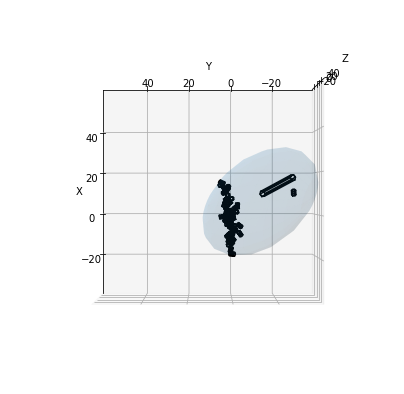

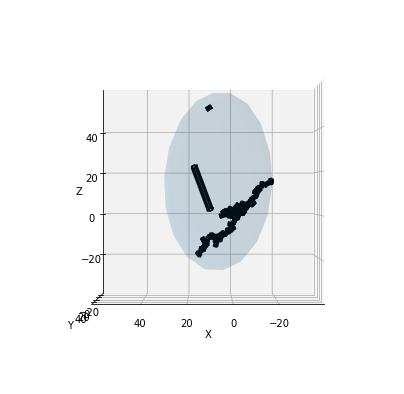

False 8.858667904100823 100.0 0.173926042087539


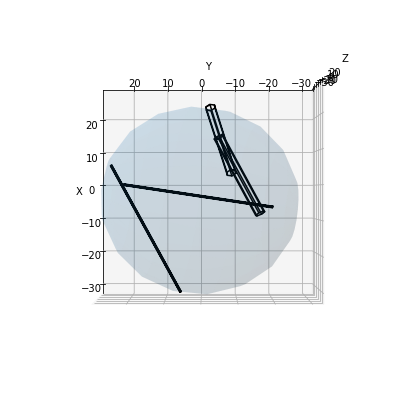

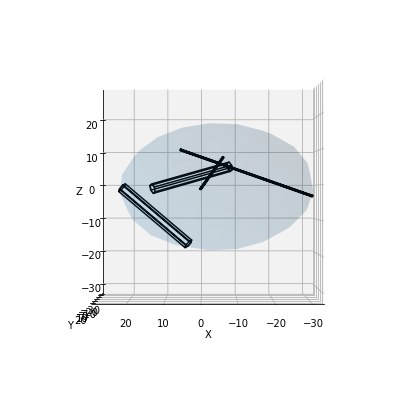

False 100.0 1.2742749857031335 0.051502537151727854


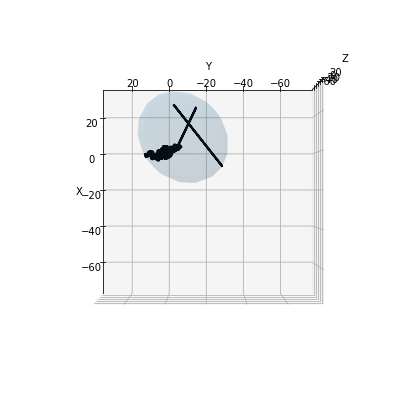

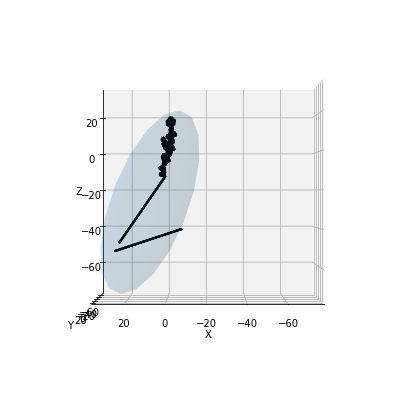

False 1.2742749857031335 8.858667904100823 0.18219868573934772


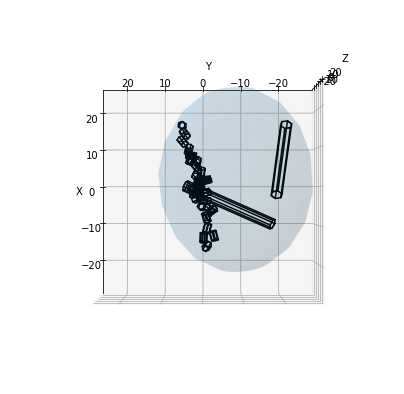

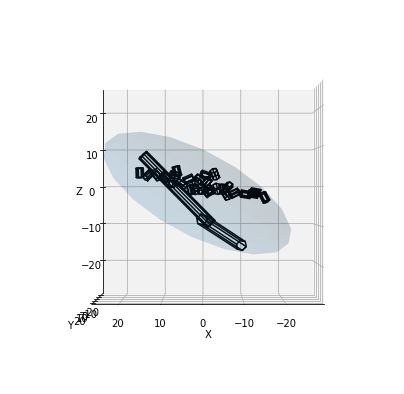

False 8.858667904100823 1.2742749857031335 0.13602669331646575


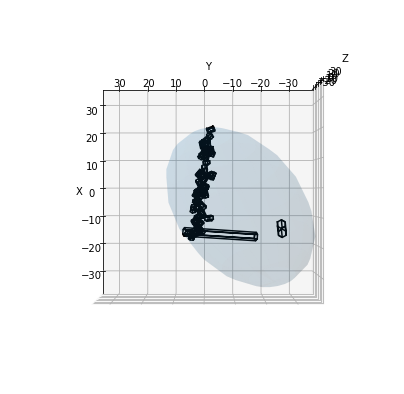

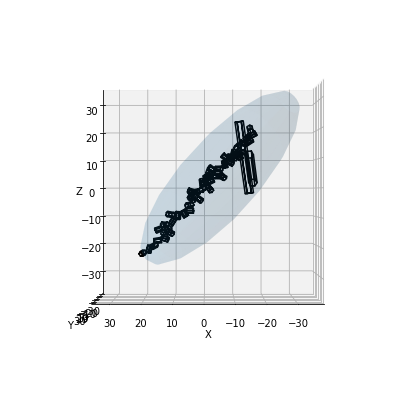

False 1.2742749857031335 1.2742749857031335 0.1244654383480202


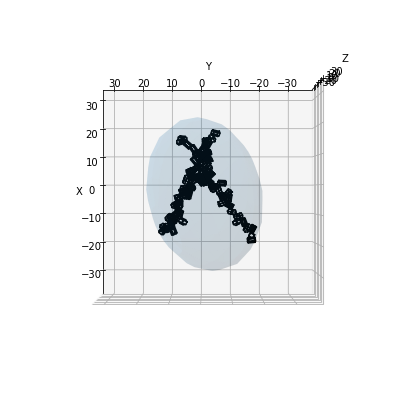

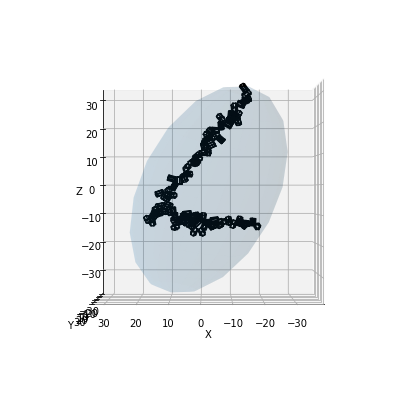

False 1.2742749857031335 23.357214690901213 0.1972758955335924


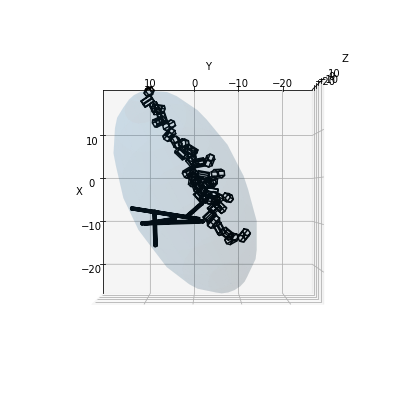

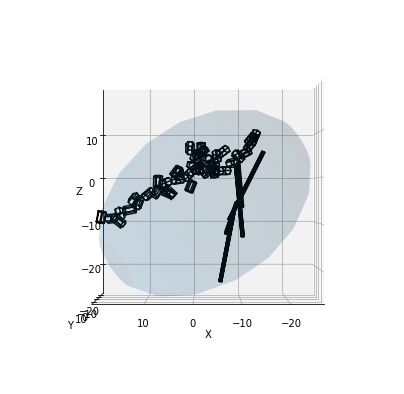

False 23.357214690901213 2.06913808111479 0.16544510421093672


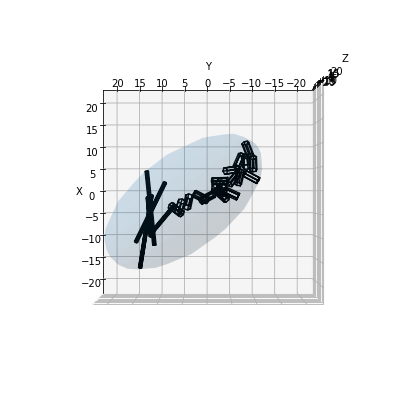

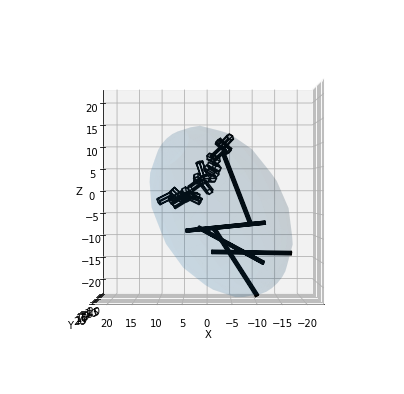

False 2.06913808111479 1.2742749857031335 0.17999952862136442


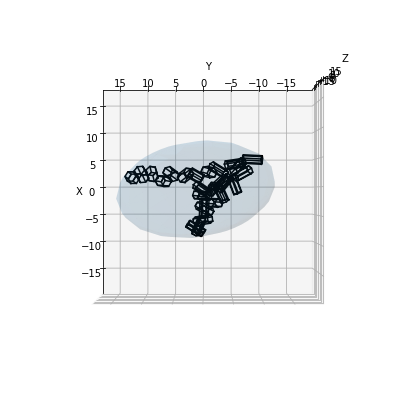

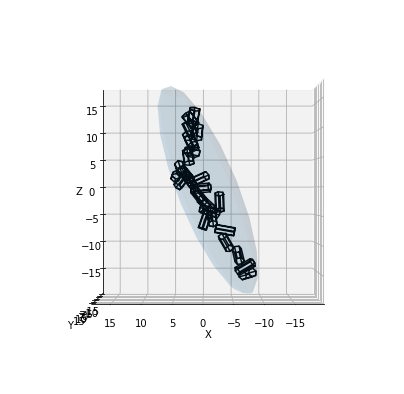

False 1.2742749857031335 1.2742749857031335 0.1516812760742097


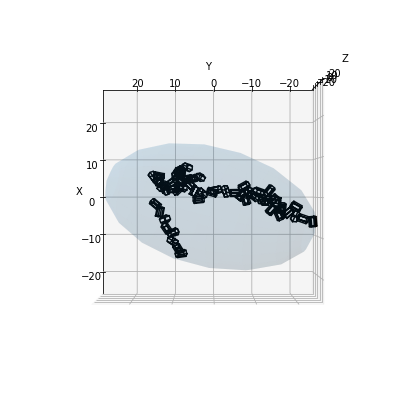

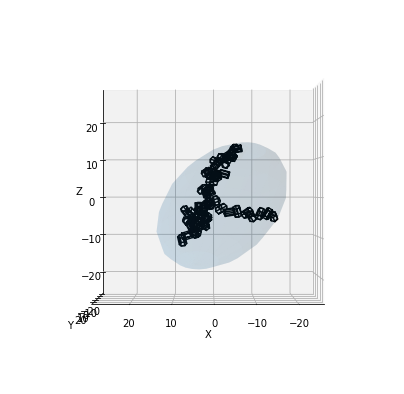

False 1.2742749857031335 1.2742749857031335 0.15021235449799764


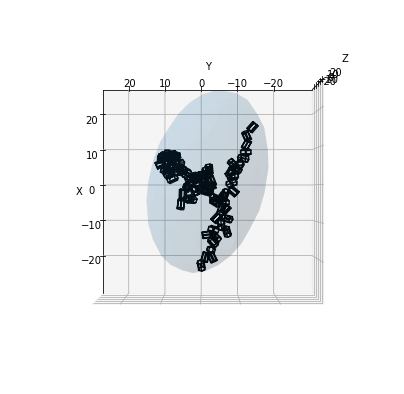

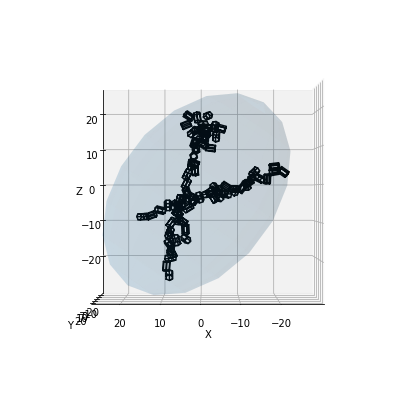

False 1.2742749857031335 2.06913808111479 0.1250647579481808


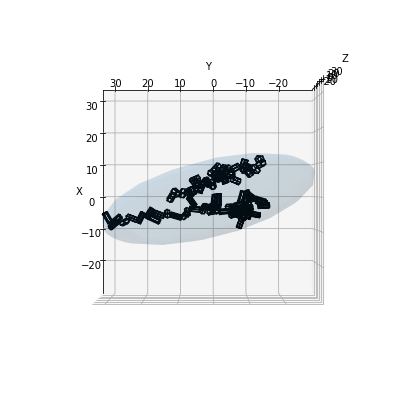

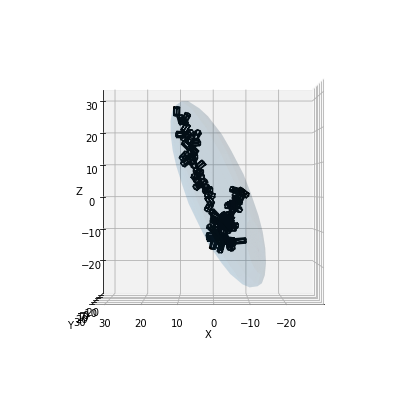

False 2.06913808111479 1.2742749857031335 0.19256979986957493


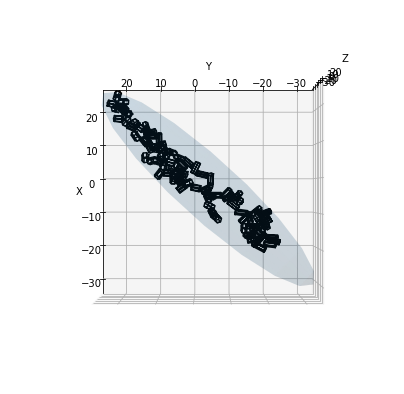

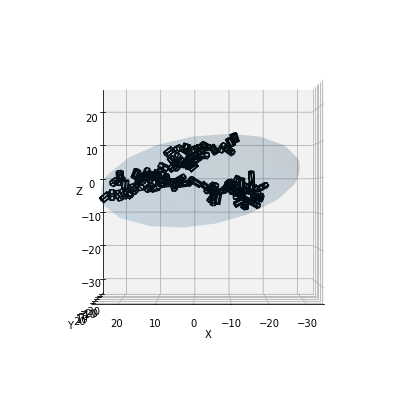

False 1.2742749857031335 1.2742749857031335 0.16722677145041911


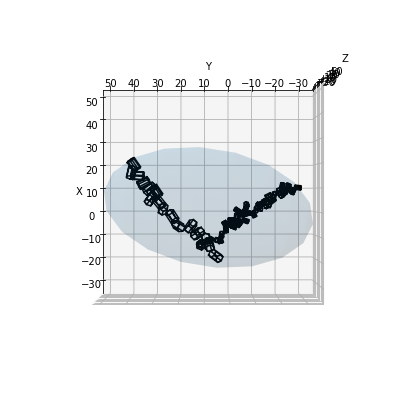

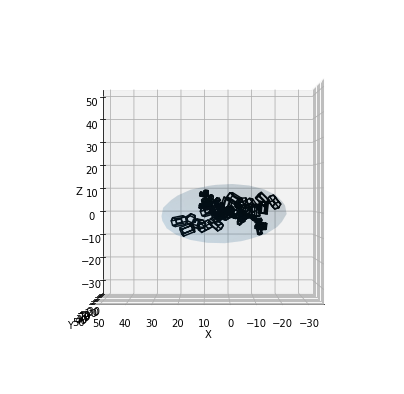

False 1.2742749857031335 3.3598182862837804 0.19138685494176813


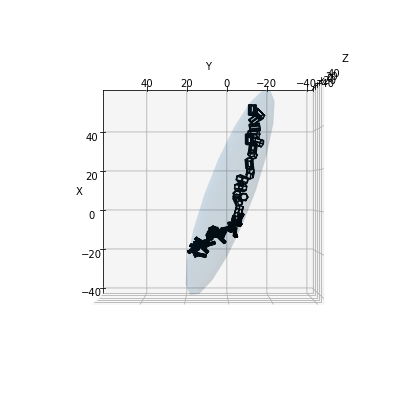

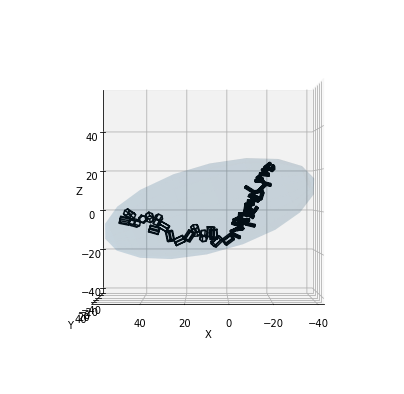

False 3.3598182862837804 1.2742749857031335 0.1971497231883755


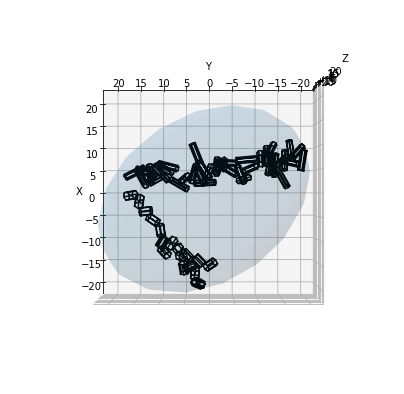

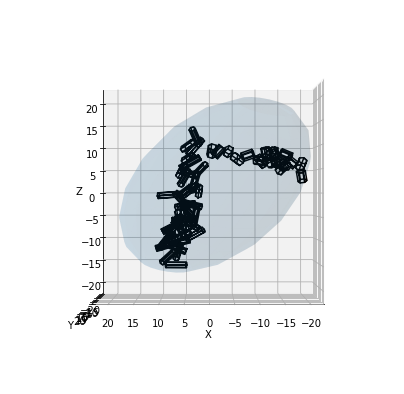

False 1.2742749857031335 1.2742749857031335 0.1999474496563604


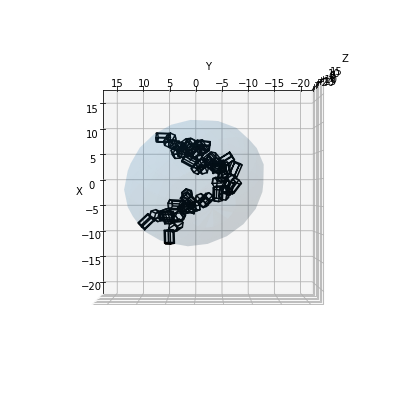

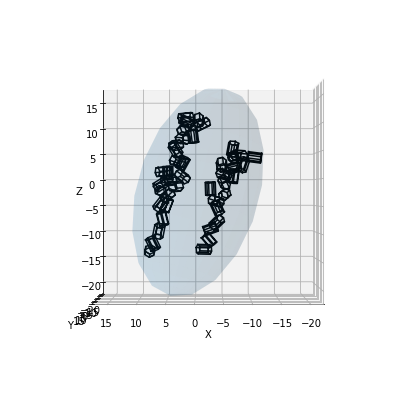

False 1.2742749857031335 2.06913808111479 0.18980645192247433


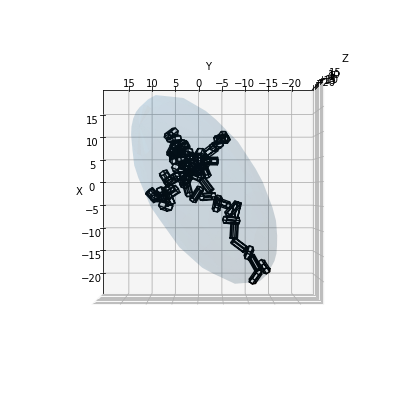

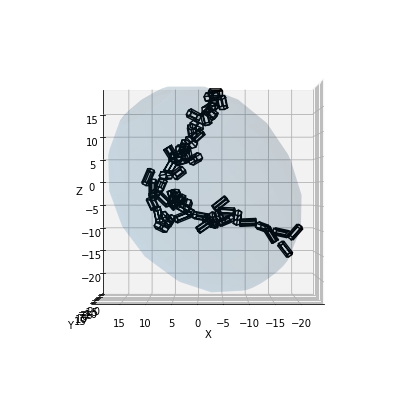

False 2.06913808111479 1.2742749857031335 0.17891087831440902


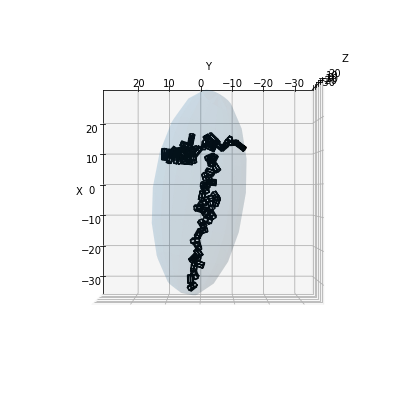

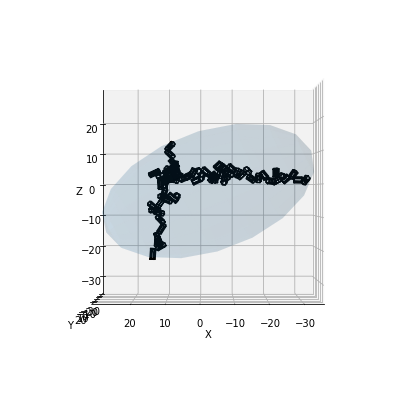

False 1.2742749857031335 2.06913808111479 0.13323099736090305


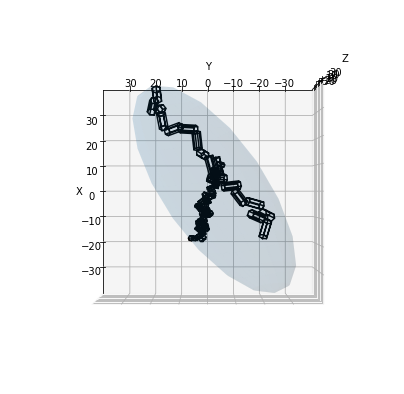

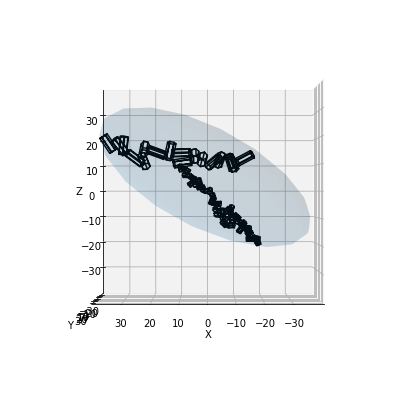

False 2.06913808111479 1.2742749857031335 0.12350789071827269


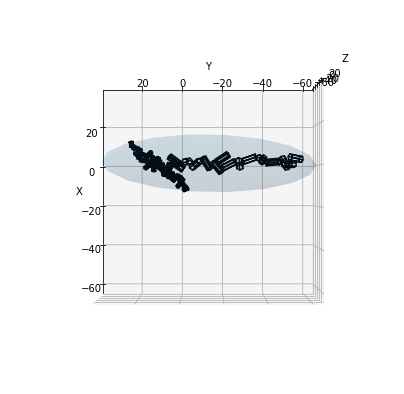

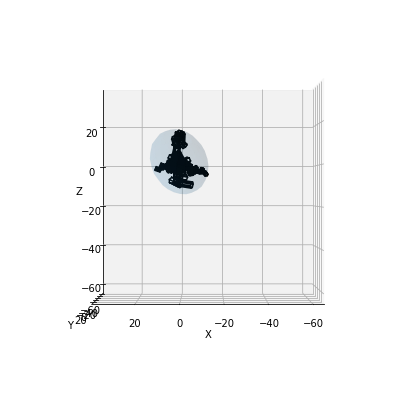

False 1.2742749857031335 2.06913808111479 0.1803750046474266


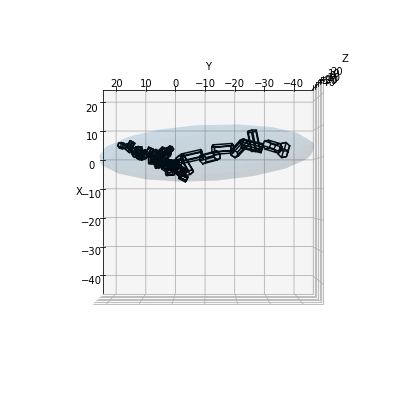

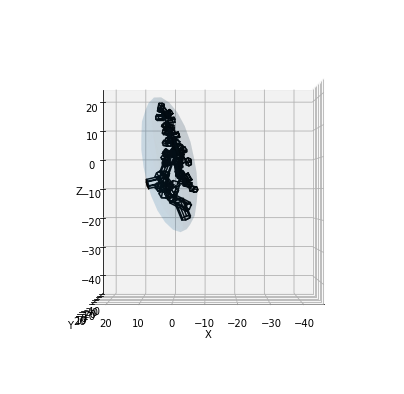

False 2.06913808111479 2.06913808111479 0.18866776213033284


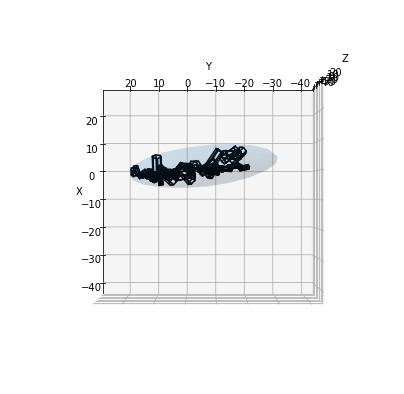

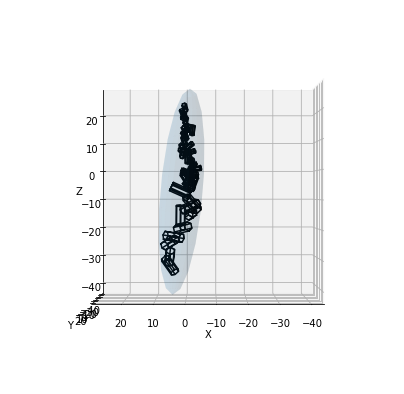

False 2.06913808111479 1.2742749857031335 0.13668931849165172


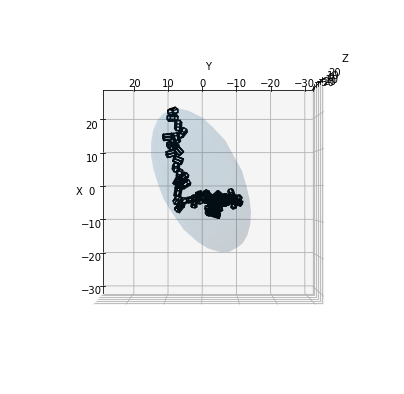

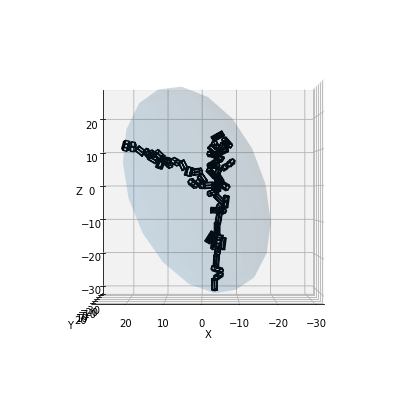

False 1.2742749857031335 8.858667904100823 0.20656205201857392


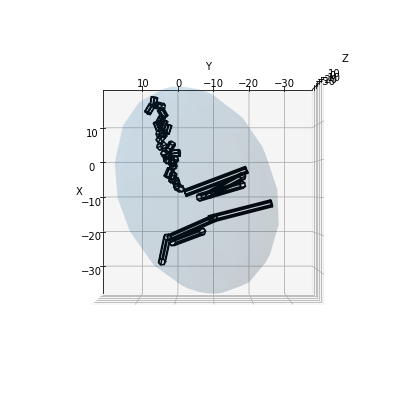

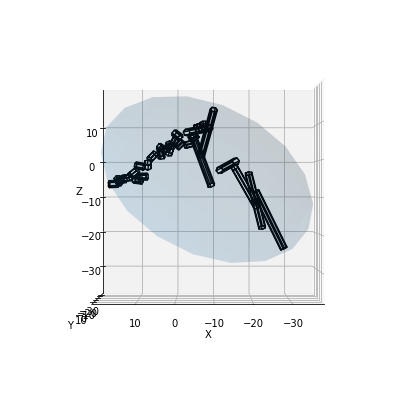

False 8.858667904100823 3.3598182862837804 0.1829929237373896


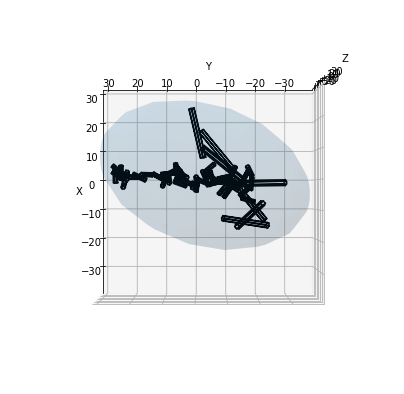

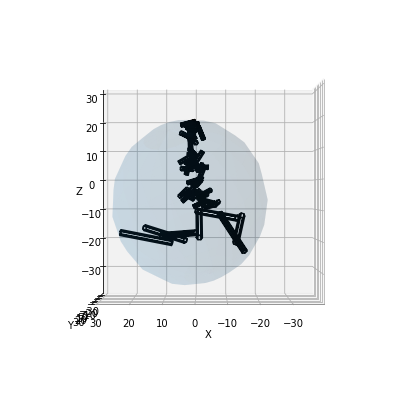

False 3.3598182862837804 23.357214690901213 0.1747413277134017


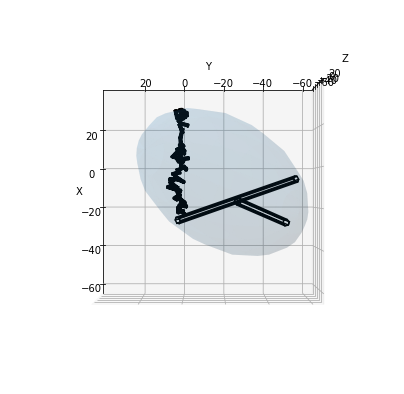

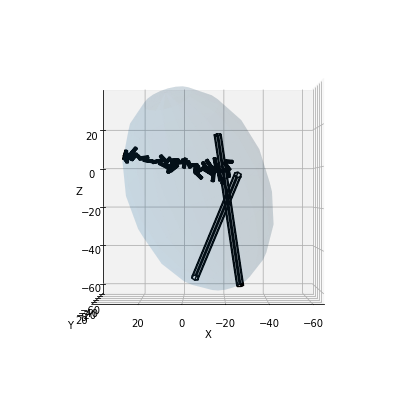

False 23.357214690901213 1.2742749857031335 0.08989227820107039


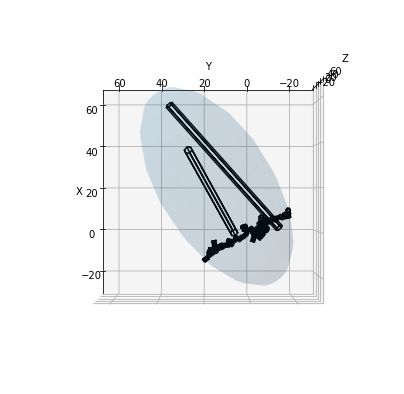

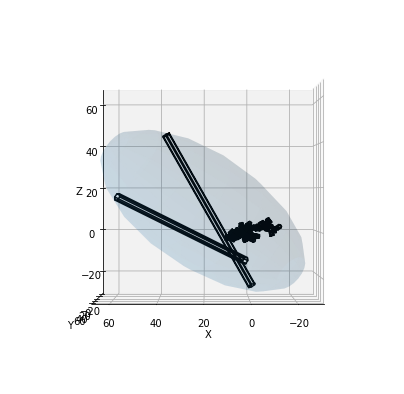

False 1.2742749857031335 1.2742749857031335 0.18774749952829145


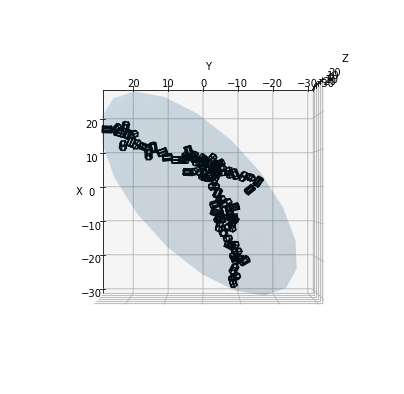

KeyboardInterrupt: 

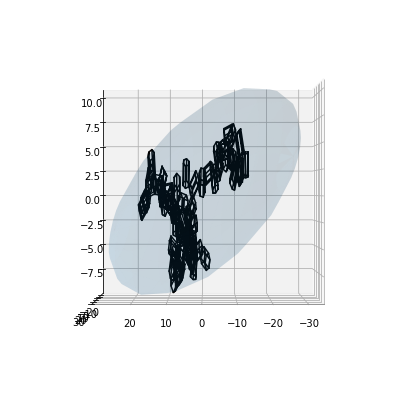

In [39]:
if __name__ == '__main__':
    agg_phi_bins = 20
    agg_r_bins = 20
    nclusters = 301
    output, hold_clusters = main()
    rxs, rys, rzs, phi2Ds, cplxs, dd, cluster1_ncrystals, cluster2_ncrystals = compute()
    results = {'rxs': rxs, 'rys':rys, 'rzs':rzs, 'phi2Ds':phi2Ds, \
                'cplxs':cplxs, 'dd':dd, 'cluster1_ncrystals':cluster1_ncrystals,\
                'cluster2_ncrystals':cluster2_ncrystals}
   
#     filename = 'instance_files/pulled_clusters_rand_aggagg_even'
#     filehandler = open(filename, 'wb')
#     pickle.dump(hold_clusters, filehandler)
#     filehandler.close()
#     print('finished!')
    
#     filename = 'instance_files/instance_db_aggagg_rand_even'
#     filehandler = open(filename, 'wb')
#     pickle.dump(results, filehandler)
#     filehandler.close()

In [ ]:
with parallel_backend("loky"):
    output = Parallel(n_jobs=-1)(delayed(ipas.collect_clusters)(cluster, rand_orient=rand_orient) for cluster in clusters)
    print(output)   